<a href="https://colab.research.google.com/github/Gaspayer/Kaggle-Titanic-competition-solution/blob/main/Titanic_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This is a full code for training and optimising a neural network predicting Titanic disaster survivors and creating a submission file for kaggle competition


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt

import os
from google.colab import drive
drive.mount('/content/gdrive')

le = preprocessing.LabelEncoder()

# Set pandas display options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# DEBUG: log device in use
#tf.debugging.set_log_device_placement(True)

Mounted at /content/gdrive


In [ ]:
# Accessing and preprocessing data

# Import data from csv files
train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/test.csv")
gender_subs = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/gender_submission.csv")

# Delete useless data columns from data frames
train = train.drop(['Ticket','Cabin','Name','PassengerId'],axis=1)
x_test = test.drop(['Ticket','Cabin','Name','PassengerId'],axis=1)

# Define categorical columns, that need to be encoded
CATEGORICAL_COLUMNS = ['Sex','Embarked']#,'Ticket','Cabin'

# Split training data into x and y
x_train = train.drop(["Survived"],axis=1)
y_train = train["Survived"]

# DEBUG: Check dimensions
#print(" dimensions x_test:" + str(x_train.shape[0]) +","+ str(x_test.shape[1]))

# Encode categorical columns for training and test data sets
for col in CATEGORICAL_COLUMNS:
    x_train[col] = le.fit_transform(x_train[col])
    x_test[col] = le.fit_transform(x_test[col])

# DEBUG: Print the mean of each column
#print(x_train.mean(axis=0))

# Replace NaN symbols with 0 
x_train["Age"] = x_train['Age'].fillna(0)
x_test["Age"] = x_test['Age'].fillna(0)

# DEBUG: Pring number of 0s in training set:
#print(np.count_nonzero(np.asarray(x_train)[:,2]==0))

# Divide dataset by max value of the respective column
x_test = x_test.div(x_train.max(axis=0), axis=1)
x_train = x_train.div(x_train.max(axis=0), axis=1)

# Subtract mean value to nomalize dataset
x_test = x_test.sub(x_train.mean(axis=0), axis=1)
x_train = x_train.sub(x_train.mean(axis=0), axis=1)

# DEBUG: Print test and train sets:
#x_train
#x_test

In [ ]:
# Defining model and regularizers

# Define regularizers
regul = tf.keras.regularizers.L1L2(l1=1e-3,l2=3e-5)

# Define keras model
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(None, 7)),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regul),
    tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile model, define optimizer and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Analytics (useful functions helping to understand the training process):

def plot_loss(history,start=5):
    # summarize history for accuracy
    plt.plot(history.history['loss'][start:], label="loss")
    plt.plot(history.history['val_loss'][start:], label = "val_loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    
def plot_accuracy(history,start=0):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'][start:], label="accuracy")
    plt.plot(history.history['val_accuracy'][start:], label = "val_accuracy")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# Convert pandas dataframe to numpy array

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# DEBUG: Check data shape
#print(x_train.shape)
#print(y_train.shape)
#print(x_val.shape)
#print(y_val.shape)

# DEBUG: Print training data
#print(x_train)

# DEBUG: Plot features
#plt.figure(1)
#for i in range(0,x_train.shape[1]):
#    plt.scatter(x_train[:,i],np.arange(0,x_train.shape[0]))
#    plt.show()

In [ ]:
# Show model summary

# Run teration to compile model to be able to show summary
model.fit(x_train, y_train, epochs=1, validation_split=0.3)

# Show model summary
model.summary()

20/20 [==============================] - 4s 27ms/step - loss: 13.8745 - accuracy: 0.2167 - val_loss: 10.8947 - val_accuracy: 0.6418
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [ ]:
#Train for a 1000 iterations with a 30% validation set
his = model.fit(x_train, y_train, epochs=1000, validation_split=0.3)

Epoch 1/1000
20/20 [==============================] - 0s 8ms/step - loss: 8.6847 - accuracy: 0.5056 - val_loss: 6.2740 - val_accuracy: 0.6418
Epoch 2/1000
20/20 [==============================] - 0s 7ms/step - loss: 5.0411 - accuracy: 0.5843 - val_loss: 3.5096 - val_accuracy: 0.6418
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 2.8595 - accuracy: 0.5778 - val_loss: 2.0151 - val_accuracy: 0.6418
Epoch 4/1000
20/20 [==============================] - 0s 9ms/step - loss: 1.8415 - accuracy: 0.5891 - val_loss: 1.4923 - val_accuracy: 0.6418
Epoch 5/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.4459 - accuracy: 0.5859 - val_loss: 1.2402 - val_accuracy: 0.6418
Epoch 6/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.2599 - accuracy: 0.5939 - val_loss: 1.1183 - val_accuracy: 0.6418
Epoch 7/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.1566 - accuracy: 0.6148 - val_loss: 1.0440 - val_accuracy: 0.6418
Epoch 

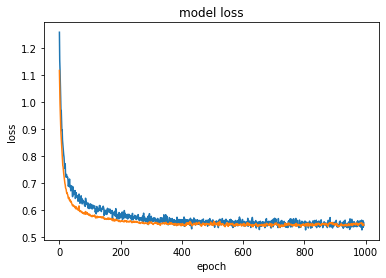

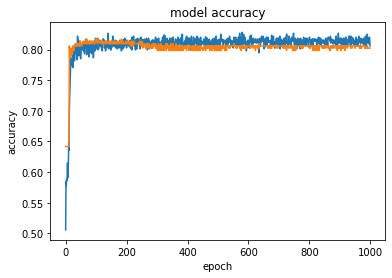

In [ ]:
# Plot loss and accuracy to determine if furthure training is necessary
plot_loss(his)
plot_accuracy(his)

In [ ]:
# Save model to file: model_titanic.h5
model.save('/content/gdrive/MyDrive/Colab Notebooks/model_titanic.h5')

In [ ]:
# Make predictions on a test set and save them to: submission_titanic.csv

# Make predictions
test_preds = model.predict(x_test)[:,0]

# Convert probability to binary
for i in range(0,test_preds.shape[0]):
  if(test_preds[i] >= 0.5): test_preds[i] = 0
  else: test_preds[i] = 1

# Add a column with passenger IDs
test_preds = np.concatenate((np.arange(892,1310)[:,np.newaxis],test_preds[:,np.newaxis]),axis=1)

# Add a header (| PasengerId | Survived |)
header = np.asarray(["PassengerId","Survived"])[np.newaxis,:]

# convert array into pandas DataFrame
DF = pd.DataFrame(test_preds).astype(int)
 
# save the DataFrame as a csv fileii
DF.to_csv("/content/gdrive/MyDrive/Colab Notebooks/submission_titanic.csv",header=["PassengerId","Survived"],index=False)

14/14 [==============================] - 0s 2ms/step


In [ ]:
#Following cell is an algorithm allowing to conduct a grid search for the optimal pameter values

# Define model
def define_model(L1,L2):
  regul = tf.keras.regularizers.L1L2(l1=L1,l2=L2)
  model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(None, 7)),
      tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regul),
      tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',#sparse_categorical_crossentropy
            metrics=['accuracy'])
  return model

# Define function for training the model that returns training history
def train_model(model):
  his= model.fit(x_train, y_train, epochs=1000,validation_split=0.3,verbose=1)
  return his

# Define lists containing results of each grid evaluation
his_list = []
last_loss_list = []
last_val_loss_list = []
# For each element in 3x3 grid:
for i in (3e-4,1e-3,3e-3):
  for j in (3e-5,1e-4,3e-4):
    # Define a new model with new parameters from the grid
    print("----------------element: " + str(i) + "," + str(j) + " --------------------")
    model = define_model(i,j)
    his = train_model(model)
    # Save history as well as last training loss and validation loss for future analysis
    his_list.append(his)
    last_loss_list.append(his.history['loss'][-1])
    last_val_loss_list.append(his.history['val_loss'][-1])

# Finally print last val_loss for every grid element to compare training performance with different parameter values
print("Grid search results:")
print("0,0: " + str(last_val_loss_list[0]) + ", 0,1: " + str(last_val_loss_list[1]) + ", 0,2: " + str(last_val_loss_list[2]) )
print("1,0: " + str(last_val_loss_list[3]) + ", 1,1: " + str(last_val_loss_list[4]) + ", 1,2: " + str(last_val_loss_list[5]) )
print("2,0: " + str(last_val_loss_list[6]) + ", 2,1: " + str(last_val_loss_list[7]) + ", 2,2: " + str(last_val_loss_list[8]) )

In [ ]:
ii# Plot history of loss for every item from grid search
for his in his_list:
  plot_loss(his,100)